In [3]:
import os
import copy
import functools
import win32com.client

import lmfit
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import linregress, norm
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model, mcmc
from sivqed.models.fitter import single_siv_ref, two_siv_ref, cavity_ref, three_siv_ref
from sivqed.models.diffusion import diffused_siv_peaks, plot_diffused_contrasts

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [4]:
datafolder_path = win32com.client.Dispatch("WScript.Shell").CreateShortCut("../data.lnk").Targetpath
siv_path = datafolder_path + "/20210903_siv_linescan/"

# List of 2-tuples, first is the avg file (which contains the freq values), second is the scans file
siv_files = [["Edown_Ndown/linescan_down_down_low-readingtrace_x_18_01_33.txt", "Edown_Ndown/linescan_down_down_low-readingtracescans_18_01_33.txt"],  
             ["Edown_Ndown_overnight/linescan_downe_downn_low-readingtrace_x_10_37_06.txt", "Edown_Ndown_overnight/linescan_downe_downn_low-readingtracescans_10_37_06.txt"],
             ["Edown_Nup/linescan_downe_upn_low-readingtrace_x_20_49_32.txt", "Edown_Nup/linescan_downe_upn_low-readingtracescans_20_49_33.txt"],
             ["Eup_Ndown/linescan_upe_downn_low-readingtrace_x_22_45_37.txt", "Eup_Ndown/linescan_upe_downn_low-readingtracescans_22_45_38.txt"],
             ["Eup_Nup/linescan_upe_upn_low-readingtrace_x_23_49_04.txt", "Eup_Nup/linescan_upe_upn_low-readingtracescans_23_49_04.txt"]
            ]

# Combined Fits + Spectral Diffusion

In [5]:
# Consider using diffusion to blur the output
spectral_diffusion = 0.03

# Sample within 2 stdev
delta_lst = np.linspace(-2*spectral_diffusion, 2*spectral_diffusion, 21)

# Weigh using a normalized Gaussian
normal_pdf = np.array([norm.pdf(delta, 0, spectral_diffusion) for delta in delta_lst])
normal_pdf /= sum(normal_pdf) 

def get_val_from_model(params, scan_idx, model, w):   
    w_c = params[f"w_c"]
    k_in = params["k_in"]
    k_tot = params["k_tot"]
    B = params["B"]
    gamma_up = params[f"gamma_up"]
    
    A = params[f"A_scan{scan_idx}"]
    w_up = params[f"w_up_scan{scan_idx}"]
    g_up = params[f"g_up_scan{scan_idx}"]
    args = [w_up, g_up, gamma_up, w_c, k_in, k_tot, A, B]
    
    # Use diffusion to blur the output
    diffused_output = np.array([model(w + delta, *args) for delta in delta_lst])
    convolved_output = np.sum([diffused_output[i] * normal_pdf[i] for i in range(len(normal_pdf))], axis=0)
    
    return convolved_output
#     return model(w, *args)

def objective(params, freqs_lst, data_lst, model_list):
    residuals_lst = np.array([])
    
    for scan_idx in range(len(data_lst)):
        
        freqs = freqs_lst[scan_idx]
        data = data_lst[scan_idx]
        model = model_list[scan_idx]

        residual = data - get_val_from_model(params, scan_idx, model, freqs)
        residuals_lst = np.append(residuals_lst, residual)

    return residuals_lst

def collect_folder_data(folder_idx):

    siv_freqs = np.loadtxt(siv_path + siv_files[folder_idx][0])
    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
    siv_intensity = np.loadtxt(siv_path + siv_files[folder_idx][1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    return siv_freqs, siv_intensity_avg

def fit_combined_data(fit_params, objective, model_list, w_up_guesses):
            
    siv_freqs_list = []
    siv_data_list = []

    for scan_idx in range(len(siv_files)):
        
        siv_freqs, siv_data = collect_folder_data(scan_idx)
        siv_freqs_list.append(siv_freqs)
        siv_data_list.append(siv_data)
        
        w_up_guess = w_up_guesses[scan_idx]
        fit_params.add(f"w_up_scan{scan_idx}", value=w_up_guess, min=w_up_guess-1, max=w_up_guess+1)
        fit_params.add(f"g_up_scan{scan_idx}", value=5.6, min=1, max=20)
        fit_params.add(f"A_scan{scan_idx}", value=10, min=1, max=20)

    out = lmfit.minimize(objective, fit_params, args=(siv_freqs_list, siv_data_list, model_list), method="lbfgsb")
    return out

# FIt all SiVs with varying k_tot

In [6]:
fit_params = Parameters()
fit_params.add("w_c", value=610, vary=False)#min=0, max=800)
fit_params.add("gamma_up", value=0.05, vary=False)
fit_params.add('k_in', value=99, min=10, max=356)
fit_params.add("k_tot", value=130, min=10, max=356)
fit_params.add("B", value=0, vary=False)

model_list = [single_siv_ref] * len(siv_files)
w_up_guesses = [678.529, 678.489, 678.532, 679.053, 679.031]

combined_results_vary_ktot = fit_combined_data(fit_params, objective, model_list, w_up_guesses)
lmfit.report_fit(combined_results_vary_ktot)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 5184
    # data points      = 800
    # variables        = 17
    chi-square         = 79.3208734
    reduced chi-square = 0.10130380
    Akaike info crit   = -1814.88833
    Bayesian info crit = -1735.24993
[[Variables]]
    w_c:         610 (fixed)
    gamma_up:    0.05 (fixed)
    k_in:        31.1523726 +/- 0.94224183 (3.02%) (init = 99)
    k_tot:       54.5764432 +/- 1.06985407 (1.96%) (init = 130)
    B:           0 (fixed)
    w_up_scan0:  678.505518 +/- 0.00393002 (0.00%) (init = 678.529)
    g_up_scan0:  2.99084277 +/- 0.04335109 (1.45%) (init = 5.6)
    A_scan0:     13.2209138 +/- 0.16799694 (1.27%) (init = 10)
    w_up_scan1:  678.476965 +/- 0.00308398 (0.00%) (init = 678.489)
    g_up_scan1:  2.89203731 +/- 0.03446788 (1.19%) (init = 5.6)
    A_scan1:     17.7380392 +/- 0.21470104 (1.21%) (init = 10)
    w_up_scan2:  678.528640 +/- 0.00388195 (0.00%) (init = 678.532)
    g_up_scan2:  3.08652889 +

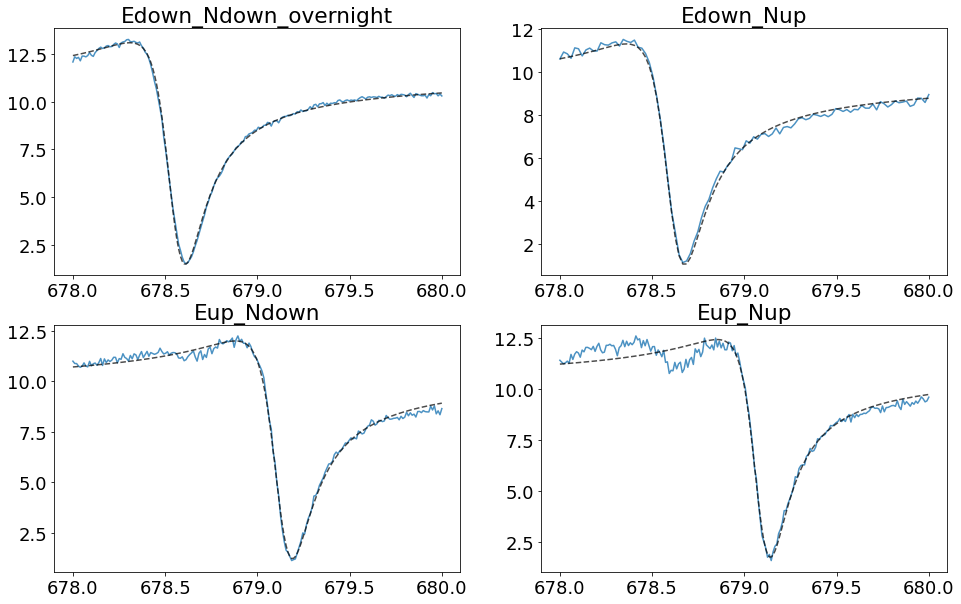

In [7]:
fig, ax = plt.subplots(figsize=[16, 10], ncols=2, nrows=2)
ax = ax.flatten()

# Ignore the first scan as it was shorter
for scan_idx, filename in enumerate(siv_files):
        if scan_idx == 0: continue    

        siv_freqs, siv_data = collect_folder_data(scan_idx)
        ax[scan_idx-1].plot(siv_freqs, siv_data, alpha=0.8)
        ax[scan_idx-1].plot(siv_freqs, get_val_from_model(combined_results_vary_ktot.params, scan_idx, 
                                           model_list[scan_idx], siv_freqs), c='k', ls='--', alpha=0.7)
        ax[scan_idx-1].set_title(filename[0].split("/")[0])

# Compute Phase difference

In [8]:
# Construct Cavity objects from the fitted parameters
cavity_objects = []

for index in range(1, 5):
    c = Cavity({"w_c" : combined_results_vary_ktot.params["w_c"], 
                "k_in" : combined_results_vary_ktot.params["k_in"], 
                "k_tot" : combined_results_vary_ktot.params["k_tot"]}, 
               {"w_up" : combined_results_vary_ktot.params[f"w_up_scan{index}"], 
                "g_up" :combined_results_vary_ktot.params[f"g_up_scan{index}"], 
                "gamma_up" : combined_results_vary_ktot.params["gamma_up"]})
    
    cavity_objects.append(c)

Text(0.5, 0, 'Frequency / GHz')

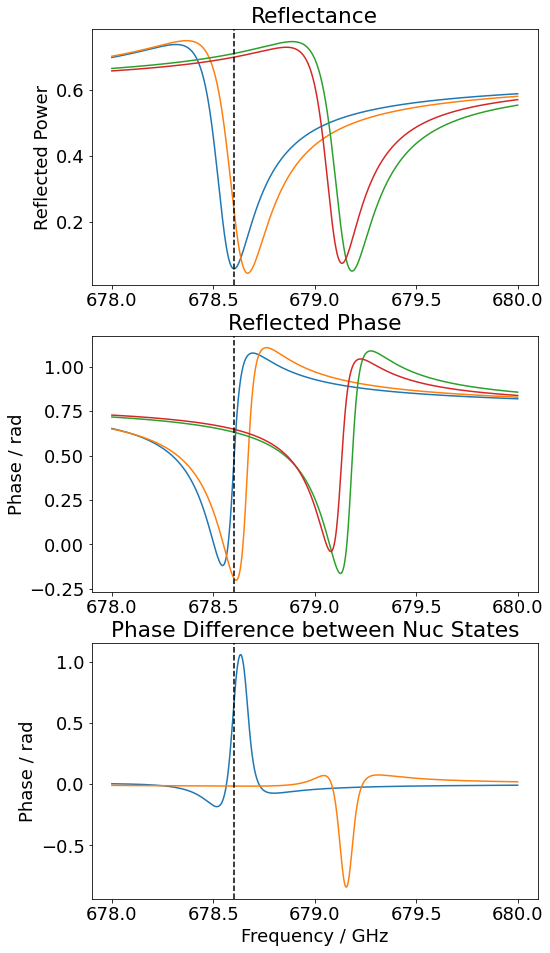

In [9]:
w_arr = np.linspace(678, 680, 1000)
fig, ax = plt.subplots(nrows=3, figsize=[8, 16])
ax = ax.flatten()

# Plot reflectance and reflected phase for 4 states
for c in cavity_objects:
    ax[0].plot(w_arr, c.reflectance(w_arr, 1))
    ax[1].plot(w_arr, c.reflected_phase(w_arr, 1))
    
# Plot difference in phase between each pair of nuclear states
ax[2].plot(w_arr, cavity_objects[0].reflected_phase(w_arr, 1) - cavity_objects[1].reflected_phase(w_arr, 1))
ax[2].plot(w_arr, cavity_objects[2].reflected_phase(w_arr, 1) - cavity_objects[3].reflected_phase(w_arr, 1))

laser_freq = 678.6
for ax_idx in range(3):
    ax[ax_idx].axvline(laser_freq, c='k', ls='--')

ax[0].set_title("Reflectance")
ax[1].set_title("Reflected Phase")
ax[2].set_title("Phase Difference between Nuc States")
ax[0].set_ylabel("Reflected Power")
ax[1].set_ylabel("Phase / rad")
ax[2].set_ylabel("Phase / rad")
ax[2].set_xlabel("Frequency / GHz")

# Test Detuning

## Repeat above plot but shift the cavity position

Phase difference per photon is 0.415 rad


Text(0.5, 0, 'Frequency / GHz')

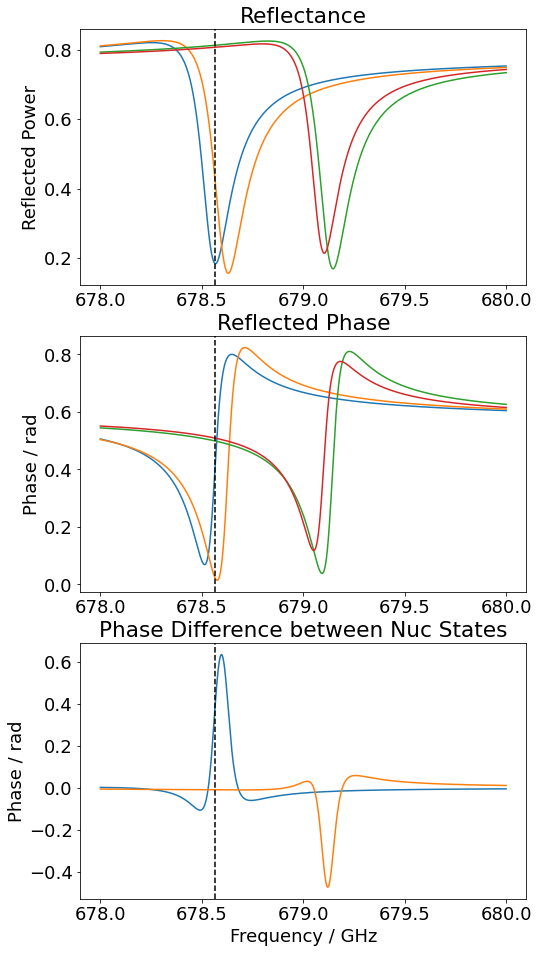

In [66]:
w_arr = np.linspace(678, 680, 12000)
fig, ax = plt.subplots(nrows=3, figsize=[8, 16])
ax = ax.flatten()

cavity_objects_copy = [copy.deepcopy(c) for c in cavity_objects]

for c in cavity_objects_copy:
    c.cavity_params["w_c"].value = 580

# Plot reflectance and reflected phase for 4 states
for c in cavity_objects_copy:
    ax[0].plot(w_arr, c.reflectance(w_arr, 1))
    ax[1].plot(w_arr, np.unwrap(c.reflected_phase(w_arr, 1)))
    
# Plot difference in phase between each pair of nuclear states
phase_diff_01 = np.unwrap(cavity_objects_copy[0].reflected_phase(w_arr, 1) - cavity_objects_copy[1].reflected_phase(w_arr, 1))
phase_diff_23 = np.unwrap(cavity_objects_copy[2].reflected_phase(w_arr, 1) - cavity_objects_copy[3].reflected_phase(w_arr, 1))
ax[2].plot(w_arr, phase_diff_01)
ax[2].plot(w_arr, phase_diff_23)

# Park laser at the min of the dip of state 00
laser_freq_idx = np.argmin(cavity_objects_copy[0].reflectance(w_arr, 1))
laser_freq = w_arr[laser_freq_idx]
for ax_idx in range(3):
    ax[ax_idx].axvline(laser_freq, c='k', ls='--')
    
print(f"Phase difference per photon is {phase_diff_01[laser_freq_idx]:.3f} rad")

ax[0].set_title("Reflectance")
ax[1].set_title("Reflected Phase")
ax[2].set_title("Phase Difference between Nuc States")
ax[0].set_ylabel("Reflected Power")
ax[1].set_ylabel("Phase / rad")
ax[2].set_ylabel("Phase / rad")
ax[2].set_xlabel("Frequency / GHz")

## Iterate over cavity position, find the phase at dip min

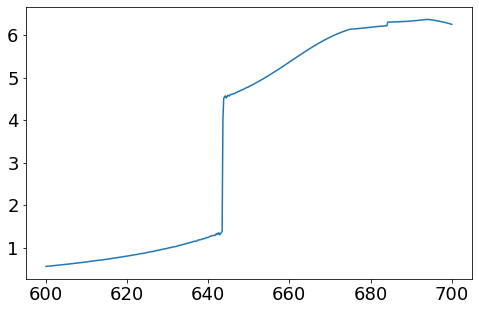

In [65]:
cavity_pos_arr = np.linspace(600, 700, 501)
w_arr = np.linspace(678, 680, 12000)
phase_diff = []

for cavity_pos in cavity_pos_arr:
    cavity_objects_copy = [copy.deepcopy(c) for c in cavity_objects]
    
    # Change all cavity positions
    for c in cavity_objects_copy:
        c.cavity_params["w_c"].value = cavity_pos

    # Difference in phase between each pair of nuclear states
    phase_diff_01 = np.unwrap(cavity_objects_copy[0].reflected_phase(w_arr, 1) - cavity_objects_copy[1].reflected_phase(w_arr, 1))

    # Park laser at the min of the dip of state 00
    laser_freq_idx = np.argmin(cavity_objects_copy[0].reflectance(w_arr, 1))

    # Phase difference per photon at laser position
    phase_diff.append(phase_diff_01[laser_freq_idx])
    
plt.plot(cavity_pos_arr, np.unwrap(phase_diff))

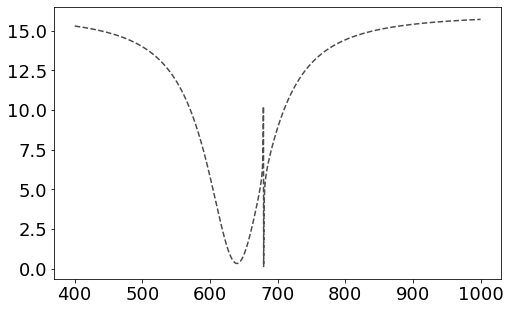

In [63]:
copy_params = copy.deepcopy(combined_results_vary_ktot.params)

copy_params["w_c"].value = 640

w_arr = np.linspace(400, 1000, 15000)
scan_idx = 3
plt.plot(w_arr, get_val_from_model(copy_params, scan_idx, 
                                   model_list[scan_idx], w_arr), c='k', ls='--', alpha=0.7)